# k-NN

by Kirill Bykov, Oleg Vlasovets, Ilya

In [1]:
#imports
import pandas as pd #pandas for reading csv file
import numpy as np  #numpy for vectorising
import seaborn as sns
from scipy.spatial import distance_matrix
from tqdm import tqdm
import math
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
%matplotlib inline

In [2]:
def read_MNIST(file_path):
    df = pd.read_csv(file_path, header = None)
    Y = np.array(df[0])
    X = np.array(df.iloc[:,1:])
    return X, Y

def first_most_frequent(arr):
    c = 0
    num = arr[0]
    for i in arr:
        amount_times = arr.count(i)
        if amount_times > c:
            c = amount_times
            num = i
    return num

def accuracy(Y_pred, Y_true):
    return np.mean(1 - np.equal(Y_true, Y_pred, dtype=int))

In [3]:
class kNN:
    
    def __init__(self, X_train, Y_train, p = 2):
        self.X_train = X_train/255.
        self.Y_train = Y_train
        self.length = len(X_train)
        self.p = p
        self.inner_distances_calculated = False
        self.test_distances_calculated = False
        
    def set_minkovsky_parameter(self, p):
        self.p = p
        self.inner_distances_calculated = False
        
    def vote(self, NN):
        n = len(NN)
        votes = np.zeros(n).astype(int)
        for i in range(0, n):
            votes[i] = first_most_frequent([self.Y_train[j] for j in NN[i]])
        return votes
    
    def predict(self, X_test, k):
        X_test = X_test/255.
        n_test = len(X_test)
        D = np.zeros((n_test, self.length))
        NN = np.zeros((n_test,k)).astype(int)
        D = pairwise_distances(X_test, self.X_train, n_jobs = -1, metric = "minkowski",
                                       p = self.p)
        for i in range(0, n_test):
            NN[i] = D[i].argsort()[:k]
        return self.vote(NN)
    
    def predict_big(self, X_test, k, partition = 500):
        if not self.test_distances_calculated or self.NN_test.shape[1]<k:
            X_test = X_test/255.
            n_test = len(X_test)
            self.NN_test = np.zeros((n_test,k)).astype(int)
            for i in tqdm(range(math.trunc(n_test/partition))):
                D = pairwise_distances(X_test[partition*i:partition*(i+1)], self.X_train,n_jobs = -1, metric = "minkowski",
                                           p = self.p)
                for j in range(partition):
                    self.NN_test[partition*i+j] = D[j].argsort()[:k]
            self.test_distances_calculated = True
        return self.vote(self.NN_test[:,:k])
    
    def LOOCV(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            self.inner_distances = pairwise_distances(self.X_train, self.X_train, n_jobs = -1, metric = "minkowski",
                                       p = self.p)
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])

    def LOOCV_big(self, k, partition = 50):
        if not self.inner_distances_calculated or self.inner_NN.shape[1]<k:
            print("Calculating distances. This could take some time ...")
            self.inner_NN = []
            for i in tqdm(range(math.trunc(self.length/partition))):
                D = pairwise_distances(self.X_train[partition*i:partition*(i+1)], self.X_train,n_jobs = -1, metric = "minkowski",
                                       p = self.p)
                for i in range(partition):
                    self.inner_NN.append(D[i].argsort()[1:k+1])
            self.inner_NN = np.array(self.inner_NN)
            self.inner_distances_calculated = True
        return self.vote(self.inner_NN[:,:k])
    
    def LOOCV_cosine(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            X_train_cur = X_train
            self.inner_distances = cdist(X_train_cur, X_train_cur, metric = "cosine");
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])
    
    def LOOCV_standard(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            X_train_cur = X_train[:,np.logical_not(np.all(X_train == X_train[0,:], axis = 0))]
            X_train_cur = (X_train_cur - np.mean(X_train_cur, axis = 0))/np.var(X_train_cur, axis = 0)
            self.inner_distances = pairwise_distances(X_train_cur, X_train_cur, n_jobs = -1, metric = "minkowski",
                                       p = self.p);
            print(self.inner_distances)
            print(np.var(X_train_cur, axis = 0))
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])
    
    def LOOCV_discr(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            self.X_train = np.around(self.X_train+0.3)
            self.inner_distances = pairwise_distances(self.X_train, self.X_train, n_jobs = -1, metric = "minkowski",
                                       p = self.p);
            print(self.inner_distances)
            print(X_train)
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True
        return self.vote(self.inner_NN[:,1:k+1])

### a)

100%|██████████| 20/20 [18:30<00:00, 128.81s/it]


Text(0, 0.5, 'Loss')

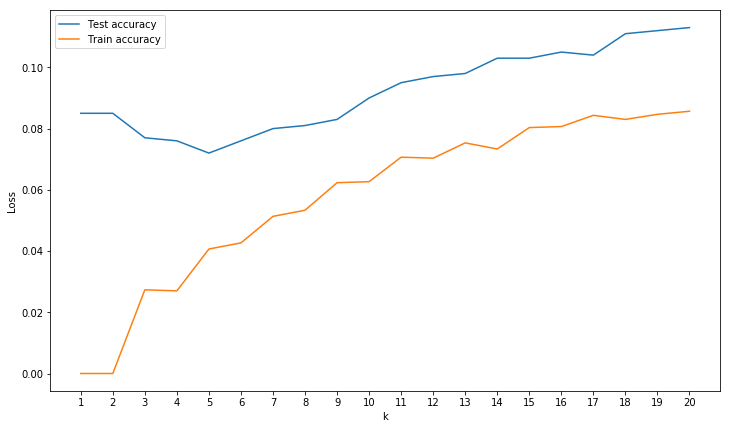

In [4]:
fig, ax = plt.subplots(figsize=(12,7))

results_test = []
results_train = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
X_test, Y_test = read_MNIST("data/MNIST_test_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred_test = classifier.predict(X_test, k)
    results_test.append(accuracy(Y_pred_test, Y_test))
    
    Y_pred_train = classifier.predict(X_train, k)
    results_train.append(accuracy(Y_pred_train, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=results_test, label = 'Test accuracy')
ax = sns.lineplot(x=[i for i in range(1,21)], y=results_train, label = 'Train accuracy')
plt.xlabel('k')
plt.xticks([i for i in range(1,21)])
plt.ylabel('Loss')

Сделайте только картинку получше

## LOOCV

*LOOCV* --- метод, который в первый раз считает расстояния между всеми точками, а затем при различных k использует уже посчитанную матрицу расстояний. Так как в памяти храним все расстояния, работает быстро, но только для маленьгоко датасета

*LOOCV_big* --- метод для работы с большими датасетами, нужно запускать начиная с максимального k, так как на первом запуске держим в памяти только соседей, и не надо пересчитывать это все для маленьких k

### b)

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


Text(0, 0.5, 'Loss')

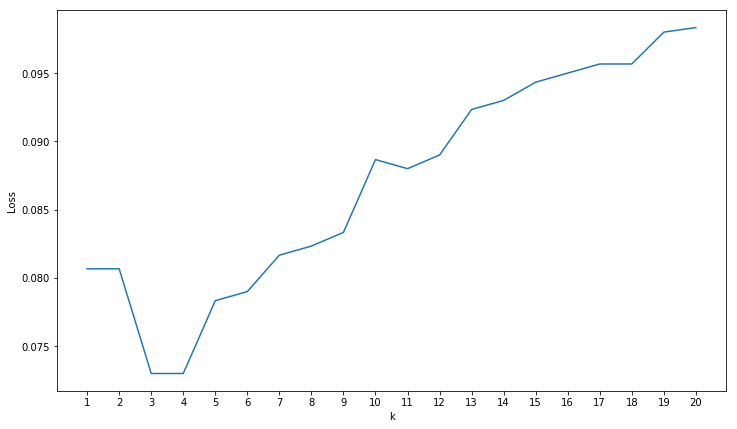

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

LOOCV_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier.LOOCV(k)
    LOOCV_results.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results)
plt.xlabel('k')
plt.xticks([i for i in range(1,21)])
plt.ylabel('Loss')

### c)

In [8]:
LOOCV_results_Mink = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for p in tqdm(range(1,16)):
    classifier.set_minkovsky_parameter(int(p))
    for k in range(1,21):
        Y_pred = classifier.LOOCV(k)
        LOOCV_results_Mink.append(accuracy(Y_pred, Y_train))

  0%|          | 0/15 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


  7%|▋         | 1/15 [00:31<07:18, 31.32s/it]

Calculating distances. This could take some time ...


 13%|█▎        | 2/15 [01:07<07:04, 32.65s/it]

Calculating distances. This could take some time ...


 20%|██        | 3/15 [03:00<11:24, 57.03s/it]

Calculating distances. This could take some time ...


 27%|██▋       | 4/15 [04:55<13:37, 74.29s/it]

Calculating distances. This could take some time ...


 33%|███▎      | 5/15 [06:51<14:28, 86.83s/it]

Calculating distances. This could take some time ...


 40%|████      | 6/15 [08:48<14:22, 95.87s/it]

Calculating distances. This could take some time ...


 47%|████▋     | 7/15 [10:44<13:35, 101.88s/it]

Calculating distances. This could take some time ...


 53%|█████▎    | 8/15 [12:41<12:24, 106.43s/it]

Calculating distances. This could take some time ...


 60%|██████    | 9/15 [14:38<10:57, 109.56s/it]

Calculating distances. This could take some time ...


 67%|██████▋   | 10/15 [16:27<09:07, 109.46s/it]

Calculating distances. This could take some time ...


 73%|███████▎  | 11/15 [18:20<07:21, 110.33s/it]

Calculating distances. This could take some time ...


 80%|████████  | 12/15 [20:14<05:35, 111.67s/it]

Calculating distances. This could take some time ...


 87%|████████▋ | 13/15 [22:09<03:45, 112.70s/it]

Calculating distances. This could take some time ...


 93%|█████████▎| 14/15 [24:01<01:52, 112.29s/it]

Calculating distances. This could take some time ...


100%|██████████| 15/15 [25:55<00:00, 112.74s/it]


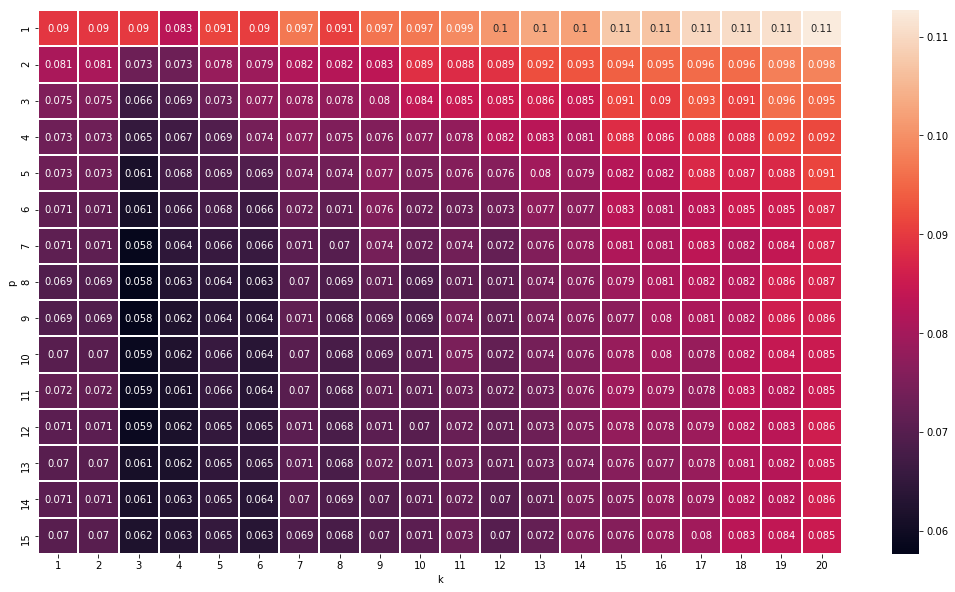

In [9]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.heatmap(np.reshape(LOOCV_results_Mink, (15,20)), linewidth=1, annot= True)
plt.xlabel('k')
plt.ylabel('p')
ax.set_xticklabels(range(1,21))
ax.set_yticklabels(range(1,16))
plt.show()

### d)

In [ ]:
LOOCV_cosine_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier_cosine = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier_cosine.LOOCV_cosine(k)
    LOOCV_cosine_results.append(accuracy(Y_pred, Y_train))

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_cosine_results)
plt.xticks([i for i in range(1,21)], fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k', fontsize = 20)
plt.ylabel('Loss', fontsize =20)

In [ ]:
LOOCV_st_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier_st = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier_st.LOOCV_standard(k)
    LOOCV_st_results.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_st_results)

In [ ]:
LOOCV_discr_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier.LOOCV_discr(k)
    print(Y_pred)
    LOOCV_discr_results.append(accuracy(Y_pred, Y_train))
    
ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_discr_results)
plt.xticks([i for i in range(1,21)], fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k', fontsize = 20)
plt.ylabel('Loss', fontsize =20)
print(LOOCV_mah_results)

### e)

  0%|          | 0/1200 [00:00<?, ?it/s]

Calculating distances. This could take some time ...



100%|██████████| 20/20 [3:40:38<00:00, 661.95s/it]


Text(0, 0.5, 'Loss')

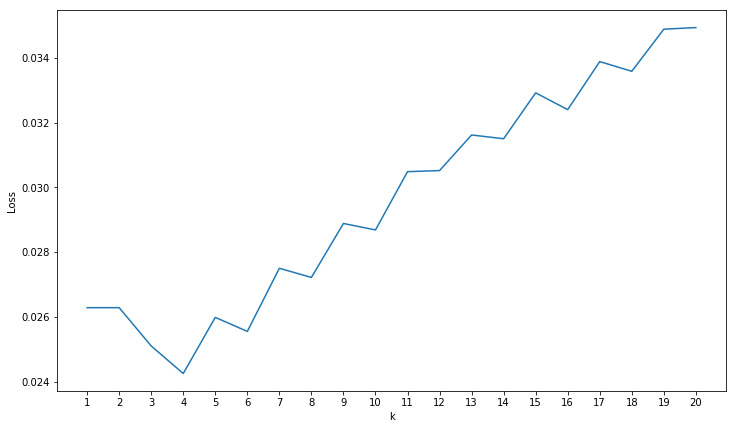

In [4]:
fig, ax = plt.subplots(figsize=(12,7))

LOOCV_big_results = []
X_train, Y_train = read_MNIST("../../MNIST_train.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(20,0,-1)):
    Y_pred = classifier.LOOCV_big(k)
    LOOCV_big_results.append(accuracy(Y_pred, Y_train))
    
ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_big_results[::-1])
plt.xticks([i for i in range(1,21)])
plt.xlabel('k')
plt.ylabel('Loss')

In [6]:
LOOCV_big_results[::-1] # от 1 до 20

[0.026283333333333332,
 0.026283333333333332,
 0.0251,
 0.02425,
 0.025983333333333334,
 0.02555,
 0.0275,
 0.027216666666666667,
 0.028883333333333334,
 0.028683333333333335,
 0.030483333333333335,
 0.030516666666666668,
 0.03161666666666667,
 0.0315,
 0.032916666666666664,
 0.0324,
 0.033883333333333335,
 0.03358333333333333,
 0.034883333333333336,
 0.03493333333333333]

### f)

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
results_test_big = []
X_train, Y_train = read_MNIST("../../MNIST_train.csv")
X_test, Y_test = read_MNIST("../../MNIST_test.csv")
classifier_big = kNN(X_train, Y_train)

for k in tqdm(range(20,0,-1)):
    Y_pred_test = classifier_big.predict_big(X_test, k)
    results_test_big.append(accuracy(Y_pred_test, Y_test))
    
ax = sns.lineplot(x=[i for i in range(1,21)], y=results_test_big[::-1], label = 'Test empirical risk')
plt.xlabel('k', fontsize = 20)
plt.xticks([i for i in range(1,21)], fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Loss', fontsize = 20)

### g)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.95).fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=140)  # project from 784 to 100 dimensions
Xproj = pca.fit_transform(X_train)

In [ ]:
print(X_train.shape)
print(Xproj.shape)

In [ ]:
approximation = pca.inverse_transform(Xproj)
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_train[1].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 140 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('140 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

In [ ]:
LOOCV_PCA_results = []
classifier_PCA = kNN(Xproj, Y_train)
for k in tqdm(range(20,0,-1)):
    Y_pred = classifier_PCA.LOOCV_big(k)
    LOOCV_PCA_results.append(accuracy(Y_pred, Y_train))
    
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_PCA_results[::-1])
plt.xticks([i for i in range(1,21)], fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)